In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import random
import time
import matplotlib.pyplot as plt
start_time = time.time()

In [2]:
n_customer = 18
n_point = n_customer + 1
vehicle_capacity = 400
crate_capacity = 43
crate_demand_per_customer = 4
min_vehicles = 2
max_vehicles = 4
max_outlets_per_vehicle = crate_capacity // crate_demand_per_customer

df = pd.DataFrame({
    'x': (23.7791509939155, 23.7057442244029, 23.7926366806198, 23.8858286334404, 23.8391319043898, 23.8583653902307, 23.9371371924135, 23.9240822361424, 23.9490218369133, 23.9195025945173, 23.6248125897135, 23.7857192154473, 23.9898643687822, 23.8091231914690, 23.9999856622965, 24.0266332915962, 23.6370879489591, 23.4664026717638, 23.8610461690743),
    'y': (90.3598076895889, 90.3914945343488, 90.2679466662192, 90.4015409619703, 90.2566349338854, 90.2619487472768, 90.2896183198397, 90.2611600411098, 90.2745243769025, 90.2111853698880, 90.4989277706365, 90.5689488781001, 90.3801430690000, 90.1480571832337, 90.2740031235854, 90.4228718359339, 90.5980341876852, 90.2872062835397, 90.0009284340897),
    'demand': (0, 42, 30, 31, 39, 34, 29, 34, 34, 32, 36, 42, 36, 33, 40, 40, 40, 47, 32),
})

In [3]:
distances = pd.DataFrame(distance_matrix(df[['x', 'y']*22000].values, df[['x', 'y']*22000].values), index=df.index, columns=df.index).values

In [4]:
def total_distance(routes):
    distance = 0
    for route in routes:
        for i in range(len(route) - 1):
            distance += distances[route[i]][route[i + 1]]
    return distance

def generate_initial_solution():
    routes = []
    customers = list(range(1, n_point))
    random.shuffle(customers)
    
    while customers:
        route = [0]
        current_load = 0
        outlets_served = 0
        while customers and (current_load + df.loc[customers[0], 'demand']) <= vehicle_capacity and outlets_served < max_outlets_per_vehicle:
            customer = customers.pop(0)
            route.append(customer)
            current_load += df.loc[customer, 'demand']
            outlets_served += 1
        route.append(0)
        routes.append(route)
    while len(routes) < min_vehicles:
        routes.append([0, 0])
    if len(routes) > max_vehicles:
        routes = routes[:max_vehicles]
    return routes
def local_search(routes):
    def two_opt(route):
        best_route = route
        best_distance = total_distance([route])
        for i in range(1, len(route) - 1):
            for j in range(i + 1, len(route)):
                new_route = route[:i] + route[i:j][::-1] + route[j:]
                new_distance = total_distance([new_route])
                if new_distance < best_distance:
                    best_route = new_route
                    best_distance = new_distance
        return best_route

    improved = True
    while improved:
        improved = False
        for i in range(len(routes)):
            new_route = two_opt(routes[i])
            if total_distance([new_route]) < total_distance([routes[i]]):
                routes[i] = new_route
                improved = True

    if len(routes) < min_vehicles:
        while len(routes) < min_vehicles:
            routes.append([0, 0])
    elif len(routes) > max_vehicles:
        routes = routes[:max_vehicles]
    
    return routes

def grasp(iterations, alpha):
    best_solution = None
    best_distance = float('inf')
    
    for _ in range(iterations):
        routes = generate_initial_solution()
        routes = local_search(routes)
        current_distance = total_distance(routes)
        
        if current_distance < best_distance:
            best_solution = routes
            best_distance = current_distance
    
    return best_solution, best_distance

iterations = 100
alpha = 0.2

In [5]:
best_solution, best_distance = grasp(iterations, alpha)
print("Status value: Success (GRASP completed)")
print("Status: Success (GRASP completed)")
print("Objective:", best_distance)
print("Number of vehicles used:", len(best_solution))

Status value: Success (GRASP completed)
Status: Success (GRASP completed)
Objective: 387.3563575664914
Number of vehicles used: 2


In [6]:
summary_data = []
for idx, route in enumerate(best_solution):
    load = 0
    outlets_served = 0
    for i in range(len(route) - 1):
        if route[i] != 0:
            load += df.loc[route[i], 'demand']
            outlets_served += 1
    summary_data.append({
        'Vehicle': idx + 1,
        'Load Carried': load,
        'Outlets Served': outlets_served
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df)


Summary Table:
   Vehicle  Load Carried  Outlets Served
0        1           341              10
1        2           310               8


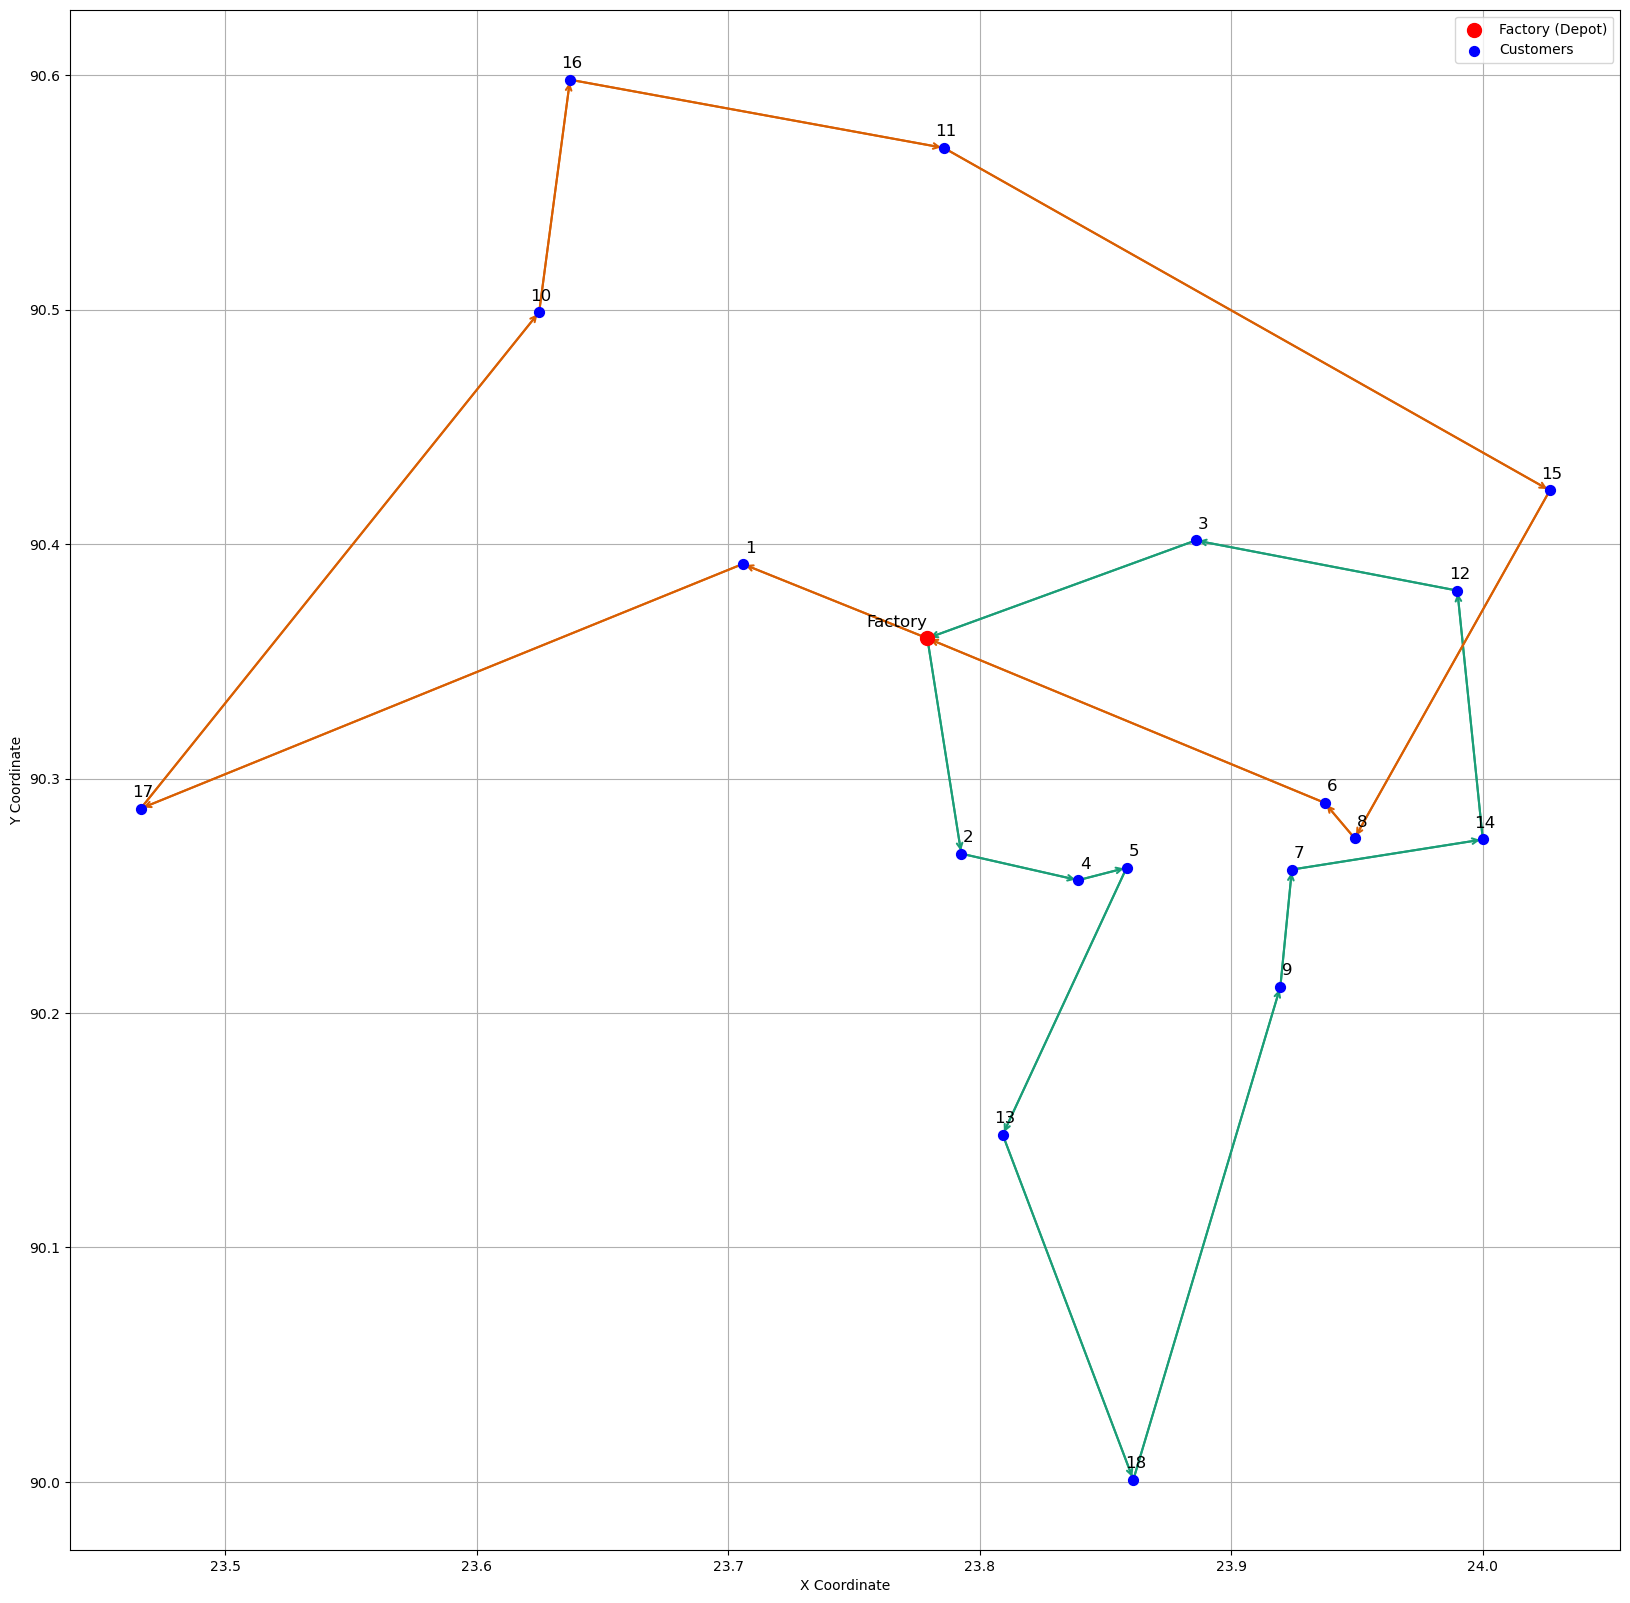

In [7]:
plt.figure(figsize=(20, 20))
plt.scatter(df['x'][0], df['y'][0], c='r', label='Factory (Depot)', s=100, zorder=3)
plt.scatter(df['x'][1:], df['y'][1:], c='b', label='Customers', s=50, zorder=3)
plt.text(df['x'][0], df['y'][0] + 0.005, 'Factory', fontsize=12, ha='right', color='black', zorder=4)
for i in range(1, n_point):
    plt.text(df['x'][i]+0.005, df['y'][i]+0.005, str(i), fontsize=12, ha='right', color='black', zorder=4)
cmap = plt.get_cmap('Dark2')
for idx, route in enumerate(best_solution):
    if len(route) > 1: 
        color = cmap(idx % 20)
        for i in range(len(route) - 1):
            plt.plot([df['x'][route[i]], df['x'][route[i + 1]]], [df['y'][route[i]], df['y'][route[i + 1]]], color=color, linestyle='-', marker='o', zorder=2)
            plt.annotate('', xy=(df['x'][route[i + 1]], df['y'][route[i + 1]]), xytext=(df['x'][route[i]], df['y'][route[i]]),
                         arrowprops=dict(arrowstyle='->', color=color, lw=1.5), zorder=2)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

Execution time: 1.6443042755126953 seconds
